# Zarr SODA 3.4.2 ds

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(25)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.75d52fce42964199be01e134b6458ec4 Dashboard: /services/dask-gateway/clusters/staging.75d52fce42964199be01e134b6458ec4/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [100]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline
xr.set_options(display_style='text');

In [2]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
url_transport = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_10dy_transport_or'
#url_ice = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ice_or'

fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)
transport = xr.open_zarr(fs.get_mapper(url_transport), consolidated=True)
#ice = xr.open_zarr(fs.get_mapper(url_ice), consolidated=True)

In [3]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

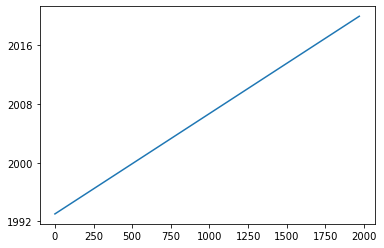

In [23]:
plt.plot(ocean.time.values)

In [4]:
import xgcm

grid_ocean = xgcm.Grid(ocean, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

In [5]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

## Variables to create:

- [ ] Vel terms for psi
- [ ] Surf flux term (incl. sw penetration)
- [ ] Total tendency term

## <font color='Green'>Get cell area and volume in meters</font>

In [6]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [7]:
#converting lat from degrees to meters
delta_lat = grid_ocean.diff(ocean.yt_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree
delta_lat_u = grid_ocean.diff(ocean.yu_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy_u = delta_lat_u * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid_ocean.diff(ocean.xt_ocean, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ocean.yt_ocean))
delta_lon_u = grid_ocean.diff(ocean.xu_ocean, 'X', boundary_discontinuity=360)
dx_u = delta_lon_u * meters_per_degree * np.cos(np.deg2rad(ocean.yu_ocean))

In [28]:
dx

<xarray.DataArray (xu_ocean: 1440, yt_ocean: 1070)>
array([[4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       ...,
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508],
       [4817.15765359, 4867.60859943, 4918.04301095, ...,  128.04559522,
          76.81169061,   25.57752508]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.74 89.84 89.95

In [29]:
dx_u

<xarray.DataArray (xt_ocean: 1440, yu_ocean: 1070)>
array([[4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       ...,
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12],
       [4.84238518e+03, 4.89282788e+03, 4.94325396e+03, ...,
        1.02428686e+02, 5.11946296e+01, 1.70218139e-12]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... 89.79 89.89 90.0

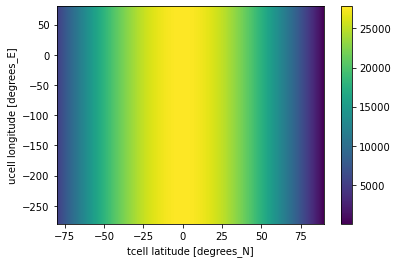

In [30]:
dx.plot()

In [8]:
dz = grid_ocean.diff(ocean.st_edges_ocean[1:], 'Z', boundary='fill', fill_value=0.)
dz_u = grid_ocean.diff(ocean.sw_edges_ocean[1:], 'Zu', boundary='fill', fill_value=0.)

In [9]:
cell_elements = xr.merge([dx.rename('dx'), dx_u.rename('dx_u'), 
                          dy.rename('dy'), dy_u.rename('dy_u'), 
                          dz.rename('dz'), dz_u.rename('dz_u')])

In [33]:
cell_elements

<xarray.Dataset>
Dimensions:   (st_ocean: 50, sw_ocean: 50, xt_ocean: 1440, xu_ocean: 1440, yt_ocean: 1070, yu_ocean: 1070)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.74 89.84 89.95
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... 89.79 89.89 90.0
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_ocean  (sw_ocean) float64 10.07 20.16 30.29 ... 5.08e+03 5.29e+03 5.5e+03
Data variables:
    dx        (xu_ocean, yt_ocean) float64 4.817e+03 4.868e+03 ... 76.81 25.58
    dx_u      (xt_ocean, yu_ocean) float64 4.842e+03 4.893e+03 ... 1.702e-12
    dy        (yu_ocean) float64 1.174e+04 1.174e+04 1.174e+04 ... 1.174e+04 nan
    dy_u      (yt_ocean) float64 nan 1.174e+04 1.174e+04 ... 1.174e+04 1.173e+04
    dz        (st_ocean) float64 10.09 10.13 10.18 ... 209.9 209.9 -5.5e+03
    dz_u      (sw_ocean) float64 10.12 10.14 10.22 ... 209.9 105.0 -5.5e+03

## <font color='Green'>Slice to WG region</font>

In [10]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [11]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [12]:
ocean_wg = ocean.isel(**lat_range, **lon_range)
transport_wg = transport.isel(**lat_range, **lon_range)
cells_wg = cell_elements.isel(**lat_range, **lon_range)

In [13]:
import xgcm

grid_ocean_wg = xgcm.Grid(ocean_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean_wg

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

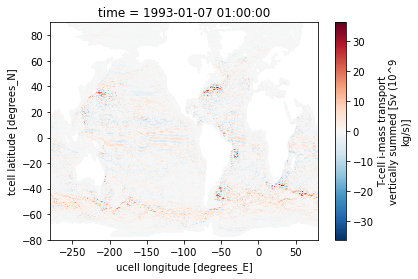

In [38]:
transport.tx_int[0].plot()

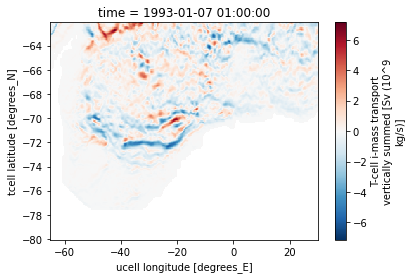

In [39]:
transport_wg.tx_int[0].plot()

## <font color='Green'>\begin{equation*} Transport/Vel\ terms \end{equation*}</font>

In [41]:
transport_wg.tx_trans.isel(xu_ocean=-1)

<xarray.DataArray 'tx_trans' (time: 985, st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(985, 50, 169), dtype=float32, chunksize=(1, 50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_t
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.0000000200408773e+20, 1.0000000200408773e+20]

In [42]:
cells_wg.dz.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [43]:
cells_wg.dy_u.coords

Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [44]:
transport_wg.ty_trans.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... -62.31 -62.2 -62.08

In [45]:
cells_wg.dx_u.coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yu_ocean  (yu_ocean) float64 -79.97 -79.86 -79.76 ... -62.31 -62.2 -62.08

In [46]:
u_transport_right = (transport_wg.tx_trans * cells_wg.dz * cells_wg.dy_u).isel(xu_ocean=-1)
u_transport_left = (transport_wg.tx_trans * cells_wg.dz * cells_wg.dy_u).isel(xu_ocean=0)

v_transport = (transport_wg.ty_trans * cells_wg.dz * cells_wg.dx_u).isel(yu_ocean=-1)

In [47]:
ocean_wg.wt[0].coords

Coordinates:
  * sw_ocean  (sw_ocean) float64 10.07 20.16 30.29 ... 5.08e+03 5.29e+03 5.5e+03
    time      object 1993-01-04 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [48]:
cells_wg.dy_u.coords

Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [15]:
dx_interp = grid_ocean_wg.interp(cells_wg.dx_u, 'Y', boundary='fill')

In [50]:
dx_interp.coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [51]:
w_transport = (ocean_wg.wt * dx_interp * cells_wg.dy_u).isel(sw_ocean=0)

In [52]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3 #rho

#surf_transport = (ocean_wg.net_heating * dx_interp * cells_wg.dy_u) / (heat_capacity_cp * runit2mass)
surf_transport = ocean_wg.net_heating  / (heat_capacity_cp * runit2mass)

In [53]:
u_transport_left[0]

<xarray.DataArray (st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(50, 169), dtype=float64, chunksize=(50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    time      object 1993-01-07 01:00:00
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

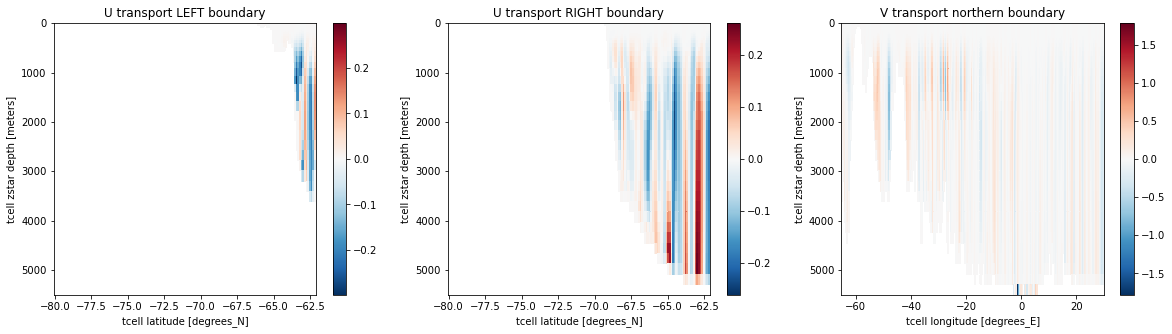

In [54]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

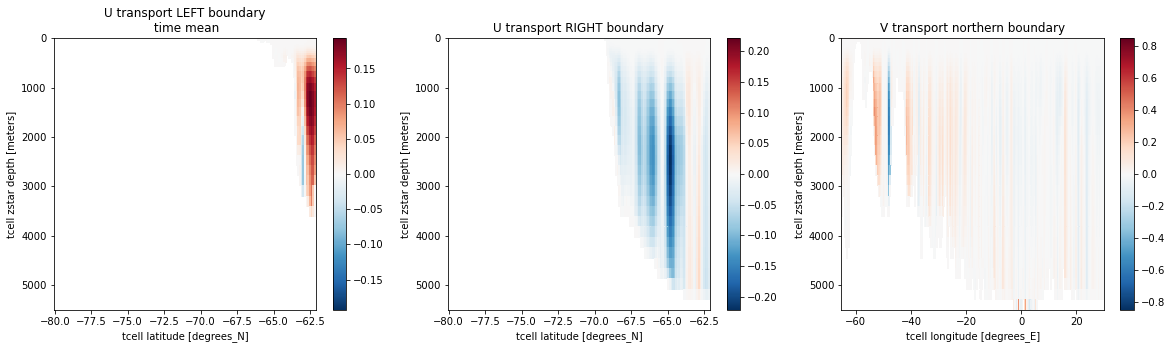

In [55]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left.mean(dim='time')/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary\n time mean')
(u_transport_right.mean(dim='time')/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport.mean(dim='time')/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [56]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.75d52fce42964199be01e134b6458ec4 Dashboard: /services/dask-gateway/clusters/staging.75d52fce42964199be01e134b6458ec4/status,Cluster Workers: 25 Cores: 50 Memory: 214.75 GB


In [71]:
u_transport_right

<xarray.DataArray (time: 985, st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(985, 50, 169), dtype=float64, chunksize=(1, 50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [72]:
u_transport_left

<xarray.DataArray (time: 985, st_ocean: 50, yt_ocean: 169)>
dask.array<getitem, shape=(985, 50, 169), dtype=float64, chunksize=(1, 50, 169), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [73]:
v_transport

<xarray.DataArray (time: 985, st_ocean: 50, xt_ocean: 381)>
dask.array<getitem, shape=(985, 50, 381), dtype=float64, chunksize=(1, 50, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    yu_ocean  float64 -62.08

In [74]:
w_transport

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
    sw_ocean  float64 10.07
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

In [75]:
surf_transport

<xarray.DataArray 'net_heating' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

In [57]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean', 'st_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean', 'st_ocean'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-69.76946809)

In [58]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean', 'st_ocean']).mean(dim='time')/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(71.82896706)
Coordinates:
    yu_ocean  float64 -62.08

In [78]:
w_transport_mean_value = (w_transport).fillna(0.).sum(dim=['xt_ocean', 'yt_ocean']).mean(dim='time')/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(0.85836276)
Coordinates:
    sw_ocean  float64 10.07

In [79]:
surf_transport_mean_value = surf_transport.fillna(0.).sum(dim=['xt_ocean', 'yt_ocean']).mean(dim='time')
surf_transport_mean_value.load()

<xarray.DataArray 'net_heating' ()>
array(-0.18487322, dtype=float32)

In [59]:
residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
residual

<xarray.DataArray ()>
array(2.05949897)
Coordinates:
    yu_ocean  float64 -62.08

## <font color='Green'>\begin{equation*} Surface\ Fluxes \end{equation*}</font>

In [81]:
ocean_wg.salt_flux_total

<xarray.DataArray 'salt_flux_total' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      sfc_salt_flux_total
    time_avg_info:  average_T1,average_T2,average_DT
    units:          kg/(m^2*sec)
    valid_range:    [-10000.0, 10000.0]

In [82]:
ocean_wg.hflux_total

<xarray.DataArray 'hflux_total' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      surface heat flux from coupler plus restore (omits mass t...
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Watts/m^2
    valid_range:    [-10000.0, 10000.0]

In [152]:
dx_interp

<xarray.DataArray (xt_ocean: 381, yt_ocean: 169)>
array([[ 2421.1925913 ,  4867.60653264,  4918.04092274, ...,
        12892.16388804, 12942.07100796, 12992.11771078],
       [ 2421.1925913 ,  4867.60653264,  4918.04092274, ...,
        12892.16388804, 12942.07100796, 12992.11771078],
       [ 2421.1925913 ,  4867.60653264,  4918.04092274, ...,
        12892.16388804, 12942.07100796, 12992.11771078],
       ...,
       [ 2421.1925913 ,  4867.60653264,  4918.04092274, ...,
        12892.16388804, 12942.07100796, 12992.11771078],
       [ 2421.1925913 ,  4867.60653264,  4918.04092274, ...,
        12892.16388804, 12942.07100796, 12992.11771078],
       [ 2421.1925913 ,  4867.60653264,  4918.04092274, ...,
        12892.16388804, 12942.07100796, 12992.11771078]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [150]:
cells_wg.dy_u.coords

Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [36]:
heat_capacity_cp = 3.994e3 #J/kg/˚C
runit2mass = 1.035e3 #rho

surf_flux_th = (ocean_wg.hflux_total * dx_interp * cells_wg.dy_u) / (heat_capacity_cp * runit2mass) #˚C*m^3/s
surf_flux_slt = (ocean_wg.salt_flux_total * dx_interp * cells_wg.dy_u) / runit2mass # psu*m^3/s

In [32]:
ocean_wg.salt_flux_total

<xarray.DataArray 'salt_flux_total' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      sfc_salt_flux_total
    time_avg_info:  average_T1,average_T2,average_DT
    units:          kg/(m^2*sec)
    valid_range:    [-10000.0, 10000.0]

In [154]:
ocean_wg.hflux_total.attrs

{'cell_methods': 'time: mean',
 'coordinates': 'geolon_t geolat_t',
 'long_name': 'surface heat flux from coupler plus restore (omits mass transfer heating)',
 'time_avg_info': 'average_T1,average_T2,average_DT',
 'units': 'Watts/m^2',
 'valid_range': [-10000.0, 10000.0]}

In [155]:
ocean_wg.hflux_cpl

<xarray.DataArray 'hflux_cpl' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      surface heat flux coming through coupler
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Watts/m^2
    valid_range:    [-10000.0, 10000.0]

In [156]:
ocean_wg.hflux_pme

<xarray.DataArray 'hflux_pme' (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 169, 381), dtype=float32, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      heat flux (relative to 0C) from pme transfer of water acr...
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Watts/m^2
    valid_range:    [-10000.0, 10000.0]

In [157]:
surf_flux_th

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [158]:
surf_flux_slt

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

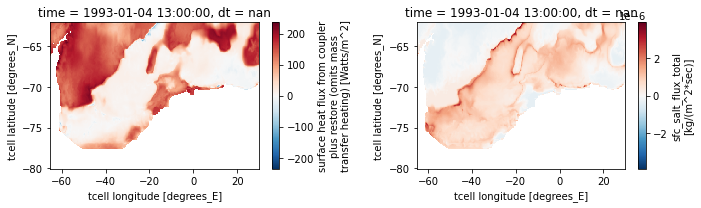

In [159]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
ocean_wg.hflux_total[0].plot(ax=ax0)
ocean_wg.salt_flux_total[0].plot(ax=ax1)
plt.tight_layout();

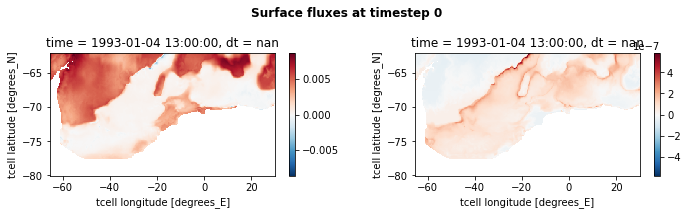

In [160]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th[0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt[0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Surface fluxes at timestep 0', fontweight='bold')
plt.tight_layout();

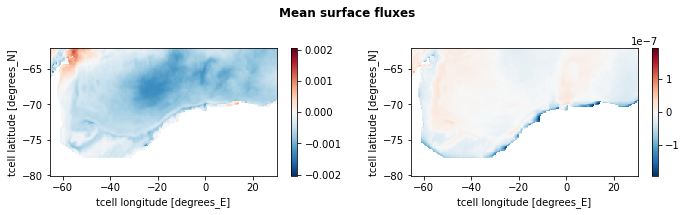

In [161]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

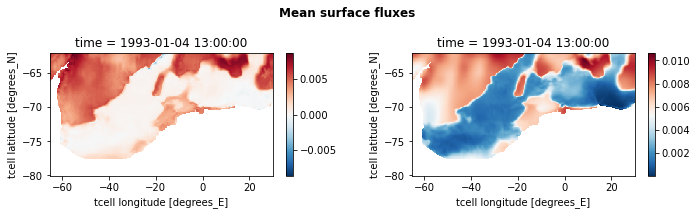

In [20]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6)[0].plot(cmap='RdBu_r', ax=ax0)
(sw_flux/1e6)[0].plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

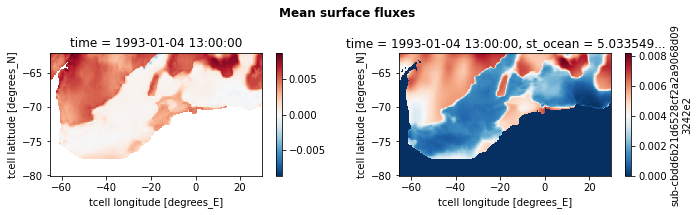

In [31]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6)[0].plot(cmap='RdBu_r', ax=ax0)
(sw_flux_conv_TH/1e6)[0, :, :, 0].plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

In [26]:
(sw_flux_conv_TH/1e6)[0, :, :, 0]

<xarray.DataArray 'sub-e9f6c20504f49dda02d3f050cf63d0d5' (yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(169, 381), dtype=float64, chunksize=(169, 381), chunktype=numpy.ndarray>
Coordinates:
    time      object 1993-01-04 13:00:00
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    st_ocean  float64 5.034

In [19]:
(surf_flux_th/1e6)[0]

<xarray.DataArray (yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(169, 381), dtype=float64, chunksize=(169, 381), chunktype=numpy.ndarray>
Coordinates:
    time      object 1993-01-04 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [18]:
(sw_flux/1e6)[0]

<xarray.DataArray (yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(169, 381), dtype=float64, chunksize=(169, 381), chunktype=numpy.ndarray>
Coordinates:
    time      object 1993-01-04 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [162]:
ocean_wg.temp

<xarray.DataArray 'temp' (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Potential temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-10.0, 500.0]

In [37]:
def surface_to_3d(da):
    da = da.copy()
    da.coords['st_ocean'] = ocean_wg.st_ocean[0]
    da = da.expand_dims(dim='st_ocean', axis=1)
    da, _ = xr.align(da, ocean_wg.st_ocean, join='right')
    return da.fillna(0.)

In [62]:
surf_flux_th

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [38]:
surf_flux_conv_TH = surface_to_3d(surf_flux_th)
surf_flux_conv_SLT = surface_to_3d(surf_flux_slt)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


## SW flux penetration

In [93]:
ocean.swflx.attrs

{'cell_methods': 'time: mean',
 'coordinates': 'geolon_t geolat_t',
 'long_name': 'shortwave flux into ocean (>0 heats ocean)',
 'standard_name': 'surface_net_downward_shortwave_flux',
 'time_avg_info': 'average_T1,average_T2,average_DT',
 'units': 'W/m^2',
 'valid_range': [-10000000000.0, 10000000000.0]}

In [94]:
ocean.swflx

<xarray.DataArray 'swflx' (time: 1970, yt_ocean: 1070, xt_ocean: 1440)>
dask.array<xarray-swflx, shape=(1970, 1070, 1440), dtype=float32, chunksize=(1, 1070, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.74 89.84 89.95
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      shortwave flux into ocean (>0 heats ocean)
    standard_name:  surface_net_downward_shortwave_flux
    time_avg_info:  average_T1,average_T2,average_DT
    units:          W/m^2
    valid_range:    [-10000000000.0, 10000000000.0]

In [17]:
#sw flux
sw_flux = (ocean_wg.swflx * dx_interp * cells_wg.dy_u) / (heat_capacity_cp * runit2mass) #˚C*m^3/s

In [167]:
sw_flux

<xarray.DataArray (time: 1970, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1970, 169, 381), dtype=float64, chunksize=(1, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [22]:
coords = ocean_wg.coords.to_dataset().reset_coords()

In [66]:
coords

<xarray.Dataset>
Dimensions:         (nv: 2, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, time: 1970, xt_ocean: 381, xu_ocean: 381, yt_ocean: 169, yu_ocean: 169)
Coordinates:
  * nv              (nv) float64 1.0 2.0
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean        (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean  (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean        (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time            (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean        (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.62 29.88
  * xu_ocean        (xu_ocean) float64 -65.0 -64.75 -64.5 ... 29.5 29.75 30.0
  * yt_ocean        (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.25 -62.14
  * yu_ocean        (yu_ocean) float64 -79.97 -79.86 -79.76 ... -62.2 -62.08
Data variables:
    *empty*
Attributes:
    filename:   soda3.4.2_5dy_ocean_or_1993_01_04.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

In [29]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""
    
    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]
    
    facz = - fact * coords.st_edges_ocean.sel(st_edges_ocean=slice(0, 215))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))
            
    return swdk.rename('swdk')

_, swdown = xr.align(ocean_wg.st_edges_ocean, sw_flux * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [28]:
coords.st_edges_ocean

<xarray.DataArray 'st_edges_ocean' (st_edges_ocean: 51)>
array([   0.      ,   10.0671  ,   20.16    ,   30.2889  ,   40.4674  ,
         50.714802,   61.057499,   71.532303,   82.189903,   93.100098,
        104.359703,  116.101402,  128.507599,  141.827606,  156.400208,
        172.683105,  191.287704,  213.020096,  238.922699,  270.309509,
        308.779297,  356.186401,  414.545685,  485.854401,  571.842773,
        673.697571,  791.842773,  925.85437 , 1074.545654, 1236.186401,
       1408.779297, 1590.30957 , 1778.922729, 1973.020142, 2171.287598,
       2372.683105, 2576.400146, 2781.827637, 2988.507568, 3196.101562,
       3404.359619, 3613.100098, 3822.189941, 4031.532227, 4241.057617,
       4450.714844, 4660.467285, 4870.289062, 5080.160156, 5290.066895,
       5500.      ])
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
Attributes:
    cartesian_axis:  Z
    long_name:       tcell zstar depth edges
    positive:        down
    units:           meters

In [33]:
#convergence of swdown
sw_flux_conv_TH = -grid_ocean_wg.diff(swdown[:,:,:,:-1], 'Z', boundary='fill')
sw_flux_conv_TH

<xarray.DataArray 'sub-cbdd6b21d6528cf2a2a9068d093242e2' (time: 1970, yt_ocean: 169, xt_ocean: 381, st_ocean: 50)>
dask.array<neg, shape=(1970, 169, 381, 50), dtype=float64, chunksize=(1, 169, 381, 49), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

## <font color='Green'>\begin{equation*} Total\ Tendency \end{equation*}</font>

In [69]:
dt_values = (ocean_wg.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], ocean_wg.time.values[1:])}) #shaves off first time stamp in `ocean_wg.time_no1980`
ocean_wg.coords['dt'] = dt


In [70]:
ocean_wg

<xarray.Dataset>
Dimensions:          (nv: 2, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, time: 1970, xt_ocean: 381, xu_ocean: 381, yt_ocean: 169, yu_ocean: 169)
Coordinates:
  * nv               (nv) float64 1.0 2.0
  * st_edges_ocean   (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean         (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean   (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean         (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time             (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean         (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.62 29.88
  * xu_ocean         (xu_ocean) float64 -65.0 -64.75 -64.5 ... 29.5 29.75 30.0
  * yt_ocean         (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.25 -62.14
  * yu_ocean         (yu_ocean) float64 -79.97 -79.86 -79.76 ... -62.2 -62.08
    dt               (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
Data variables: (12/32)
    anompb           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 169, 381), meta=np.ndarray>
    average_DT       (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    evap_heat        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 169, 381), meta=np.ndarray>
    hflux_cpl        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 169, 381), meta=np.ndarray>
    ...               ...
    tauy             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 169, 381), meta=np.ndarray>
    temp             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    time_bounds      (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    u                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    v                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    wt               (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ocean_or_1993_01_04.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

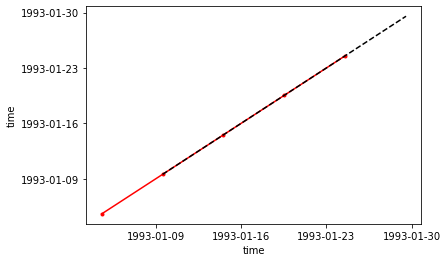

In [71]:
ocean_wg.time[0:5].plot(color='r', marker='.')
dt_values.time[0:5].plot(color='k', linestyle='dashed')

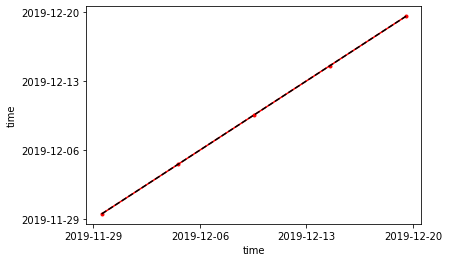

In [72]:
ocean_wg.time[-5:].plot(color='r', marker='.')
dt_values.time[-5:].plot(color='k', linestyle='dashed')

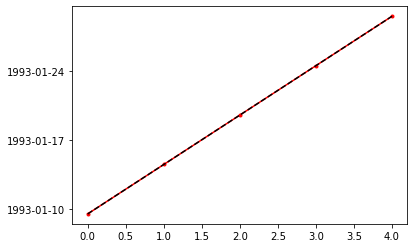

In [73]:
plt.plot(ocean_wg.time.values[1:6], color='r', marker='.')
plt.plot(dt.time.values[0:5], color='k', linestyle='dashed')

**Theta Tendency Term**

In [117]:
ocean_wg.temp

<xarray.DataArray 'temp' (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Potential temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-10.0, 500.0]

In [118]:
ocean_wg.temp.time

<xarray.DataArray 'time' (time: 1970)>
array([cftime.DatetimeJulian(1993, 1, 4, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 13, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 12, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 19, 13, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
    dt       (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05 4.32e+05

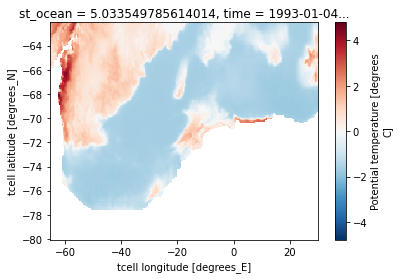

In [120]:
ocean_wg.temp[0,0].plot()

In [74]:
delta_theta = ocean_wg.temp.diff('time')#.load()

In [122]:
delta_theta.time

<xarray.DataArray 'time' (time: 1969)>
array([cftime.DatetimeJulian(1993, 1, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 19, 13, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 12, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 19, 13, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [123]:
dt.time

<xarray.DataArray 'time' (time: 1969)>
array([cftime.DatetimeJulian(1993, 1, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 19, 13, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 12, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 19, 13, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00

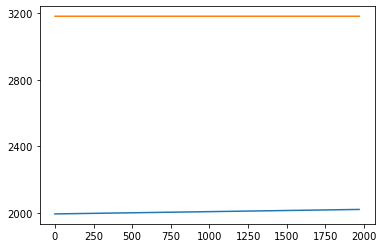

In [125]:
plt.plot(delta_theta.time.values)
plt.plot(ocean_wg.dt.values)

In [133]:
delta_theta

<xarray.DataArray 'temp' (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<sub, shape=(1969, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [136]:
delta_theta.data

,Array,Chunk
Bytes,25.36 GB,12.88 MB
Shape,"(1969, 50, 169, 381)","(1, 50, 169, 381)"
Count,9848 Tasks,1969 Chunks
Type,float32,numpy.ndarray


In [138]:
ocean_wg.dt.time.shape

(1970,)

In [75]:
#forcing delta_theta to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','st_ocean','yt_ocean','xt_ocean'], 
                            coords={'time': ocean_wg.dt[1:].time.data,
                                    'st_ocean': ocean_wg.st_ocean,
                                    'yt_ocean': ocean_wg.yt_ocean,
                                    'xt_ocean': ocean_wg.xt_ocean})
delta_theta

<xarray.DataArray 'sub-74cf1bb559497381b2debbb5a66ad414' (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<sub, shape=(1969, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88

In [76]:
theta_tend = (delta_theta / ocean_wg.dt)#.load()

In [77]:
theta_tend

<xarray.DataArray (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<truediv, shape=(1969, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

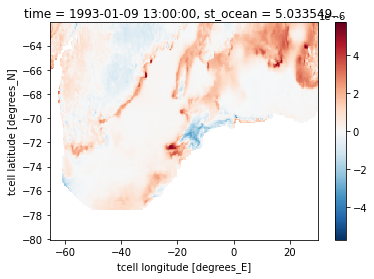

In [142]:
theta_tend[0,0].plot()

In [143]:
theta_tend.coords#[:,1:,1:,1:]

Coordinates:
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [145]:
dx_interp.coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [173]:
cells_wg.dy_u.coords

Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [175]:
cells_wg.dz.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [176]:
dz.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [78]:
totttend = theta_tend * dx_interp * cells_wg.dy_u * cells_wg.dz

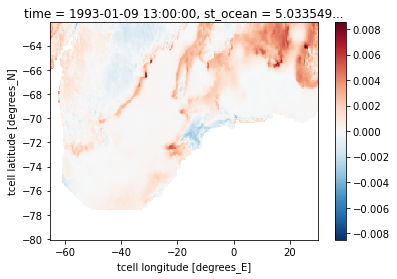

In [79]:
(totttend[0,0]/1e6).plot()

**Salt Tendency Term**

In [80]:
delta_salt = ocean_wg.salt.diff('time')

In [181]:
delta_salt

<xarray.DataArray 'salt' (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<sub, shape=(1969, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [81]:
#forcing delta_salt to have same timestamp as ds.dt by creating new data array called "salt_scaled"
delta_salt = xr.DataArray(delta_salt.data, dims=['time','st_ocean','yt_ocean','xt_ocean'], 
                            coords={'time': ocean_wg.dt[1:].time.data,
                                    'st_ocean': ocean_wg.st_ocean,
                                    'yt_ocean': ocean_wg.yt_ocean,
                                    'xt_ocean': ocean_wg.xt_ocean})
delta_salt

<xarray.DataArray 'sub-87ace75ed301d2e2489ca6ef622cf580' (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<sub, shape=(1969, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88

In [82]:
salt_tend = (delta_salt / ocean_wg.dt)

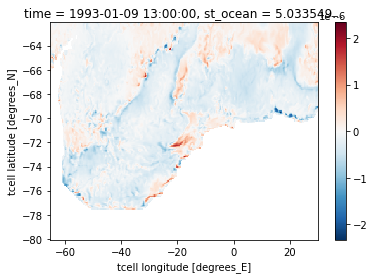

In [185]:
salt_tend[0,0].plot()

In [186]:
salt_tend.coords

Coordinates:
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [188]:
dx_interp.coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [189]:
cells_wg.dy_u.coords

Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [190]:
cells_wg.dz.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [83]:
totstend = salt_tend * dx_interp * cells_wg.dy_u * cells_wg.dz

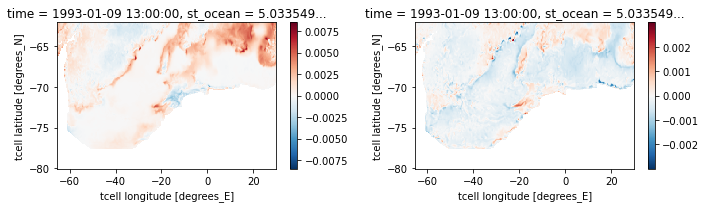

In [84]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(totstend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

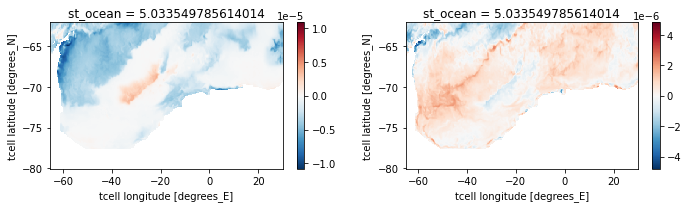

In [85]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend.isel(time=slice(0,-1), st_ocean=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(totstend.isel(time=slice(0,-1), st_ocean=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

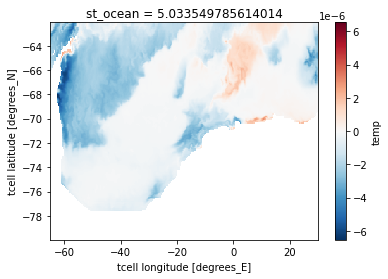

In [212]:
#lat jan minus first jan
((ocean_wg.temp[-71,0, 1:, 1:] - ocean_wg.temp[0,0, 1:, 1:])/1e6).plot(cmap='RdBu_r')#, vmax=0)#, vmin=-6e-5)

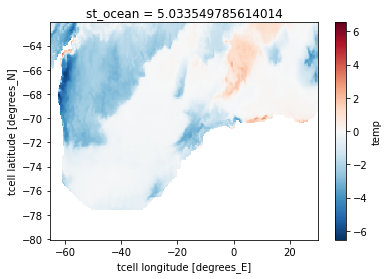

In [213]:
(ocean_wg.temp[-71, 0] - ocean_wg.temp[0, 0]).plot()

In [225]:
transport_wg.time

<xarray.DataArray 'time' (time: 985)>
array([cftime.DatetimeJulian(1993, 1, 7, 1, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 17, 1, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 27, 1, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 11, 27, 1, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 7, 1, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 17, 1, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

## Saving Data

In [269]:
ocean_resample = ocean_wg.resample(time='10D').mean()

In [34]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [87]:
ocean_wg.nbytes/1e9

163.378185912

In [274]:
ocean_resample.nbytes/1e9

81.689094232

In [88]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.75d52fce42964199be01e134b6458ec4 Dashboard: /services/dask-gateway/clusters/staging.75d52fce42964199be01e134b6458ec4/status,Cluster Workers: 24 Cores: 48 Memory: 206.16 GB


In [91]:
transport_wg.nbytes/1e9

25.876708224

In [92]:
#saving transport terms in wg region
gcfs_transport_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/transport_wg.zarr')
transport_wg.to_zarr(gcfs_transport_wg, mode='w')

In [94]:
cells_wg['dx_interp'] = dx_interp

In [95]:
#saving cell elements in wg region
gcfs_cells_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/cells_wg.zarr')
cells_wg.to_zarr(gcfs_cells_wg, mode='w')

In [39]:
surf_terms = xr.merge([surf_flux_conv_SLT.rename('surf_flux_conv_SLT'),
                       surf_flux_conv_TH.rename('surf_flux_conv_TH'),
                       sw_flux_conv_TH.rename('sw_flux_conv_TH')])

In [ ]:
gcfs_surf_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/surf_terms.zarr')
surf_terms.to_zarr(gcfs_surf_terms, mode='w')

In [98]:
totend = xr.merge([totttend.rename('totttend'),
                   totstend.rename('totstend')])

In [99]:
gcfs_totend = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/totend.zarr')
totend.to_zarr(gcfs_totend, mode='w')

In [277]:
client.close()
cluster.close()